# Softmax回归＋损失函数+图片分类数据集

In [31]:
#导入第三方库
%matplotlib inline
import torch, torchvision
from torch import nn
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
from IPython import display

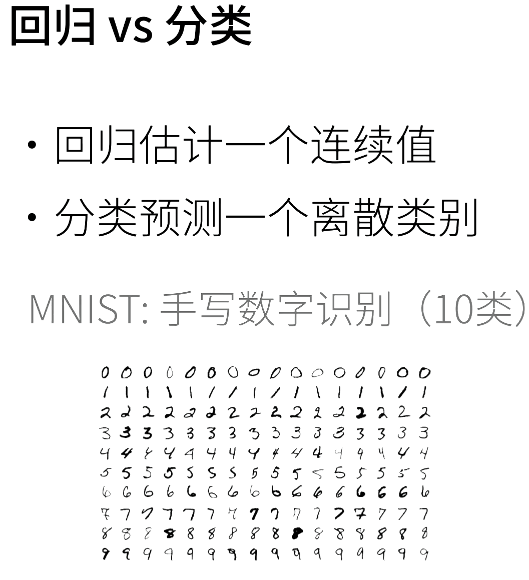

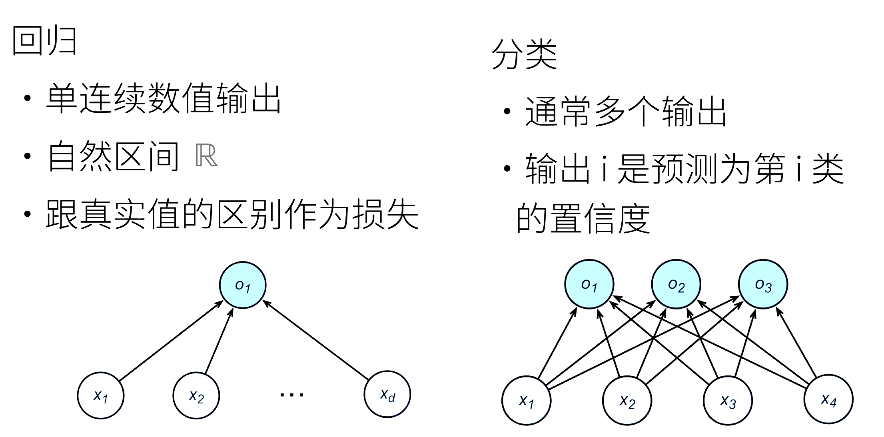

## 三个常用的损失函数
- 均方损失函数(L2 LOSS): (y - y')^2/2
- 绝对值损失函数(L1 LOSS): |y - y'|

  - 优点：整体稳定性较好  缺点：在0点处不可导
- 哈勃鲁棒损失函数(Huber's Robust Loss) 

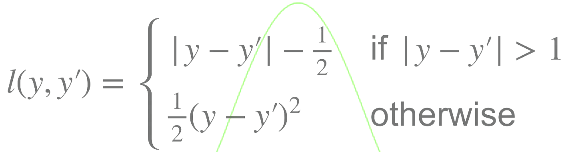

## 图像分类数据集

MNIST数据集是图像分类中广泛使用的数据集之一，但作为基准数据集过于简单，这里使用更复杂的Fashion-MNIST数据集

In [2]:
#用svg格式显示图片
d2l.use_svg_display()

In [3]:
#分别读取训练数据集和测试数据集
#通过ToTensor实例将图像数据变换为32位浮点数格式并除以255使所有像素的均值在0到1之间
mnist_train = torchvision.datasets.FashionMNIST(root= '../data', train= True, transform= transforms.ToTensor(), download= True)
mnist_test = torchvision.datasets.FashionMNIST(root= '../data', train= False, transform= transforms.ToTensor(), download= True) 
len(mnist_train), len(mnist_test)

(60000, 10000)

In [4]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [5]:
#两个可视化数据集的函数
def get_fashion_mnist_labels(labels):
    """
    返回Fashion-MNIST数据集的文本标签
    """
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'skirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles= None, scale= 1.5):
    """
    展示数据集的图片
    """
    figsize = (num_cols*scale, num_rows*scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize= figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            #图片张量
            ax.imshow(img.numpy())
        else:
            #PIL图片
            ax.imshow(img)

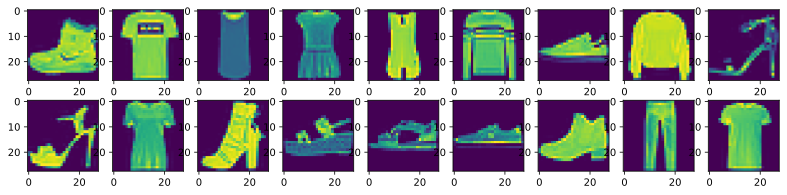

In [6]:
#展示图片及其对应的标签
X, y = next(iter(data.DataLoader(mnist_train, batch_size= 18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles= get_fashion_mnist_labels(y))

In [7]:
batch_size = 256
#使用多cpu线程读取数据
def get_dataloader_workers():
    """使用cpu的4个线程读取数据"""
    return 4
#设置训练器
train_iter = data.DataLoader(mnist_train, batch_size, shuffle= True, num_workers= get_dataloader_workers())

#查看数据加载时间
timer = d2l.Timer()
for X, y in train_iter:
    continue

print(f'{timer.stop():.2f} sec')

3.20 sec


In [8]:
#定义load_data_fashion_mnist函数
def load_data_fashion_mnist(batch_size, resize= None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root= "../data", train= True, transform= trans, download= True)
    mnist_test = torchvision.datasets.FashionMNIST(root= "../data", train= False, transform= trans, download= True)
    #返回训练器以及测试器
    return (data.DataLoader(mnist_train, batch_size, shuffle= True, num_workers= get_dataloader_workers()), 
            data.DataLoader(mnist_test, batch_size, shuffle= True, num_workers= get_dataloader_workers()))

## softmax回归的从零开始实现

In [9]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize= None)

In [10]:
#展平每个图像，将每个图片视为长度为784的向量。数据集中有10个类别，所以模型的输出类别为10
num_inputs = 784
num_outputs = 10

w = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad= True)
b = torch.zeros(num_outputs,  requires_grad= True)

In [11]:
#实现softmax
def softmax(X):
    """实现softmax分类"""
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim= True)
    #使用广播机制
    return X_exp / partition


In [12]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0878, 0.1642, 0.0187, 0.4559, 0.2734],
         [0.1384, 0.2808, 0.3347, 0.1333, 0.1127]]),
 tensor([1.0000, 1.0000]))

In [13]:
#实现softmax模型
def net(X):
    """
    实现softmax的模型计算，传入模型的矩阵形式为y = wx+b
    """
    #torch.matmul()方法实现矩阵乘法
    return softmax(torch.matmul((X.reshape(-1, w.shape[0])), w) + b)

In [14]:
#实现交叉熵损失函数
def cross_entropy(y_hat, y):
    """
    定义交叉熵损失,实现方式为返回y中索引值对应y_hat的最大概率值,然后套用公式计算得出
    """
    return -torch.log(y_hat[range(len(y_hat)), y])

In [15]:
#将预测类别与真实y元素进行比较
def accuracy(y_hat, y):
    """
    计算预测正确的数量。
    """
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        #返回y的预测值矩阵中每一行元素值最大的那一项的下标
        y_hat = y_hat.argmax(axis= 1)
        #将将预测正确的数量赋值给cmp，y_hat转换成和y一样的变量类型
        cmp = y_hat.type(y.dtype) == y
        return float(cmp.type(y.dtype).sum())

In [16]:
#Accumulator实例中创建了2个变量，分别用于存储正确预测的数量和预测总数量
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [17]:
#可以评估在任意模型net的准确率
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上的精度"""
    if isinstance(net, torch.nn.Module):
        #设置模型为评估模式
        net.eval()
        #正确预测数、预测总数
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [18]:
evaluate_accuracy(net, test_iter)

0.0785

In [19]:
#softmax回归的训练
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        #设置为训练模式
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            #反向传播
            l.backward()
            #更新模型参数
            updater.step()
            metric.add(
                float(1) * len(y), accuracy(y_hat, y),
                y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]


In [20]:
#定义一个在动画中绘制数据的实用程序类
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel= None, ylabel= None, legend= None, xlim= None,
                ylim= None, xscale= 'linear', yscale= 'linear',
                fmts=('-', 'm--', 'g-.', 'r:'), nrows= 1, ncols= 1,
                figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize= figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: d2l.set_axes(self.axes[0],
                                               xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    #向图表中加入多个数据点
    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[]for _ in range(n)]
        if not self.Y:
            self.Y = [[]for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait= True)

In [26]:
#训练函数
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """
    训练模型
    """
    animator = Animator(xlabel= 'epoch', xlim= [1, num_epochs], ylim= [0.3, 0.9], legend= ['train loss', 'train acc', 'test sec'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
        train_loss, train_acc = train_metrics
        assert train_loss < 0.6, train_loss
        assert train_acc <= 1 and train_acc > 0.7, train_acc
        assert test_acc <= 1 and test_acc > 0.7, test_acc

In [22]:
lr = 0.1 

def updater(batch_size):
    return d2l.sgd([w, b], lr, batch_size)

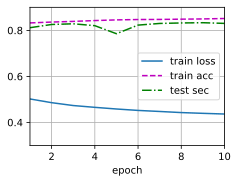

In [27]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

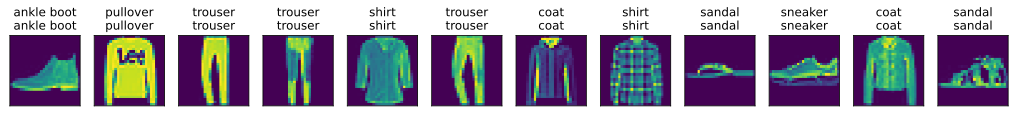

In [28]:
#模型训练完成，对图像进行预测
def predict_ch3(net, test_iter, n= 12):
    """
    预测图像类别
    """
    for X, y in test_iter:
        #中断，只取一个批量
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis= 1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape(n, 28, 28), 1, n, titles= titles[0:n])

predict_ch3(net, test_iter)

## softmax回归的简洁实现

In [29]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [34]:
#pytorch不会隐式调整输入的形状，因此，在此使用展平层(flatten)在线性层前调整网络输入的形状
net  = nn.Sequential(
        #展平输入
        nn.Flatten(),
        nn.Linear(784, 10)
       )

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std= 0.01)
    
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [35]:
#在交叉熵函数中传递未归一化的预测，并同时计算softmax及其对数
loss = nn.CrossEntropyLoss()

In [36]:
#使用学习率为0.1的小批量随机梯度下降作为优化算法
trainer = torch.optim.SGD(net.parameters(), lr= 0.1)

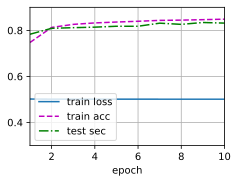

In [38]:
#调用之前定义的训练函数来训练模型
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)